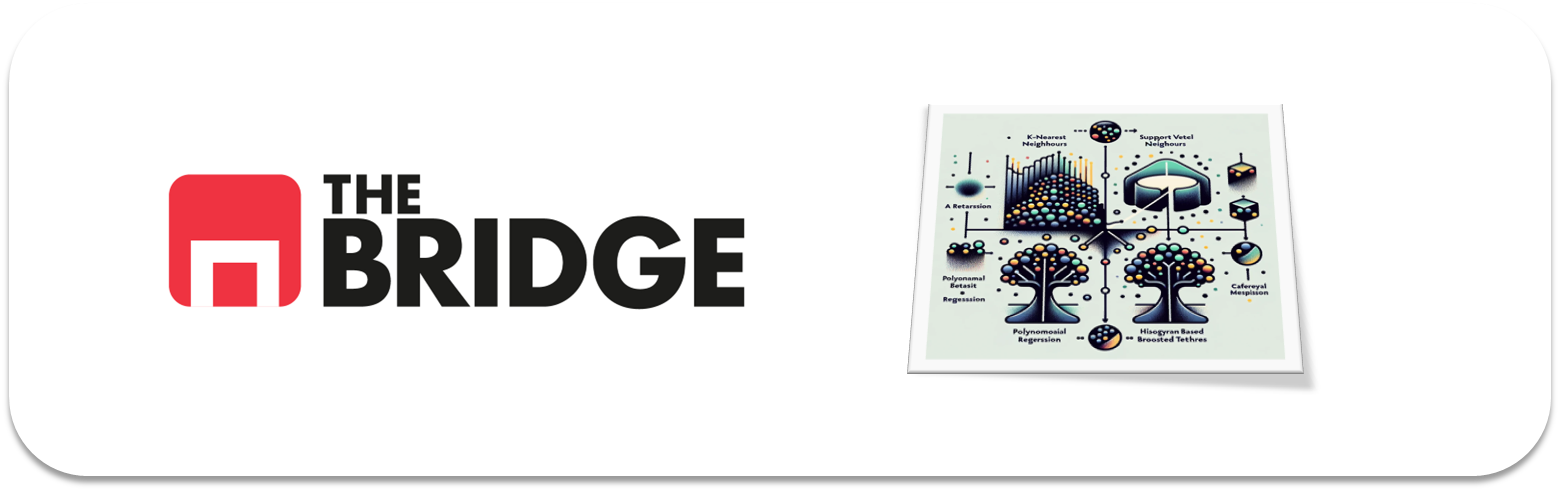

## PRACTICA OBLIGATORIA: **Otros Modelos Supervisados**

* La práctica obligatoria de esta unidad consiste en resolver un modelado de clasificación, incluyendo KNN entre los posibles modelos, y aplicando balanceado. Para ello utilizaremos un dataset que ya hemos empleado en los workout. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [285]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import toolbox_ML as tl


from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

### #1. El problema y los datos

Vamos a volver al dataset con el que vimos la clasificación binaria con regresión logística, "Give me some credit", y nuestro objetivo es crear un modelo que nos permita predicir si una persona va a encontrarse en dificultades financieras en los dos próximos años. El dataset de partida lo puedes en contrar en el directorio data que acompaña al ejercicio. 

### #1.1
Cárgalo y, apoyándote en las herramientas y fuentes que consideres necesarias, haz una descripción textual de sus variables. Luego con ayuda de los datos, haz una clasificación inicial de sus variables en categóricas y numéricas.

In [291]:
df_cred=pd.read_csv("./data/credit_npo.csv")

In [292]:
df_cred.head(5)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,0,0.070709,5656.0,12,1,0,0,0.0
1,0,0.023413,74,0,0.209197,4870.0,9,0,1,0,0.0
2,0,0.000000,43,0,0.080784,5000.0,2,0,0,0,2.0
3,0,0.492754,44,0,0.412735,7333.0,4,0,2,0,3.0
4,0,1.000000,63,0,0.000000,8333.0,3,0,0,0,1.0


In [293]:
df_cred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12537 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      12537 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  12537 non-null  float64
 2   age                                   12537 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  12537 non-null  int64  
 4   DebtRatio                             12537 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       12537 non-null  int64  
 7   NumberOfTimes90DaysLate               12537 non-null  int64  
 8   NumberRealEstateLoansOrLines          12537 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  12537 non-null  int64  
 10  NumberOfDependents                    12360 non-null  float64
dtypes: float64(4), 

### Características del Dataset

#### Las variables incluidas en el dataset son:

**SeriousDlqin2yrs**:	Variable objetivo (target). Es 1 si la persona tuvo un impago grave (default) en los últimos 2 años, y 0 si no.

**RevolvingUtilizationOfUnsecuredLines**:	Proporción del crédito disponible (no hipotecario) que está siendo usado. Por ejemplo, si tienes $10,000 de crédito disponible y usas $3,000, este valor será 0.3. Valores cercanos a 1 indican alto uso del crédito.

**age**:	Edad del individuo.

**NumberOfTime30-59DaysPastDueNotWorse**:	Número de veces que el cliente tuvo un retraso en el pago de entre 30 y 59 días, pero no peor (no más grave).

**DebtRatio**:	Proporción entre el total de deuda mensual y el ingreso mensual bruto. Por ejemplo, si pagas $1,000 al mes de deudas y ganas $4,000, tu ratio será 0.25.

**MonthlyIncome**:	Ingreso mensual del individuo. Puede tener valores faltantes o cero.

**NumberOfOpenCreditLinesAndLoans**:	Número total de líneas de crédito abiertas y préstamos (incluye tarjetas, hipotecas, etc.).

**NumberOfTimes90DaysLate**:	Número de veces que el cliente tuvo un retraso de 90 días o más en el pago. Este es un indicador importante de riesgo.

**NumberRealEstateLoansOrLines**:	Número de hipotecas o líneas de crédito relacionadas con bienes raíces (casas, propiedades, etc.).

**NumberOfTime60-89DaysPastDueNotWorse**:	Número de veces que el cliente tuvo un retraso de entre 60 y 89 días, sin contar los peores casos.

**NumberOfDependents**:	Número de dependientes del individuo (personas que dependen económicamente de él o ella, como hijos).

In [294]:
df_cred.rename(columns={
    'SeriousDlqin2yrs': 'default_2yrs',
    'RevolvingUtilizationOfUnsecuredLines': 'revolving_util',
    'NumberOfTime30-59DaysPastDueNotWorse': 'late_30_59',
    'DebtRatio': 'debt_ratio',
    'MonthlyIncome': 'monthly_income',
    'NumberOfOpenCreditLinesAndLoans': 'open_credit_lines',
    'NumberOfTimes90DaysLate': 'late_90_plus',
    'NumberRealEstateLoansOrLines': 'realestate_loans',
    'NumberOfTime60-89DaysPastDueNotWorse': 'late_60_89',
    'NumberOfDependents': 'dependents'
}, inplace=True)

In [295]:
df_cred.head(5)

,default_2yrs,revolving_util,age,late_30_59,debt_ratio,monthly_income,open_credit_lines,late_90_plus,realestate_loans,late_60_89,dependents
0,0,0.081892,37,0,0.070709,5656.0,12,1,0,0,0.0
1,0,0.023413,74,0,0.209197,4870.0,9,0,1,0,0.0
2,0,0.000000,43,0,0.080784,5000.0,2,0,0,0,2.0
3,0,0.492754,44,0,0.412735,7333.0,4,0,2,0,3.0
4,0,1.000000,63,0,0.000000,8333.0,3,0,0,0,1.0


In [296]:
df_cred.nunique()

default_2yrs             2
revolving_util       10764
age                     78
late_30_59              10
debt_ratio           11547
monthly_income        4167
open_credit_lines       43
late_90_plus            13
realestate_loans        16
late_60_89               8
dependents              10
dtype: int64

In [297]:
df_cred.isna().sum()

default_2yrs           0
revolving_util         0
age                    0
late_30_59             0
debt_ratio             0
monthly_income       721
open_credit_lines      0
late_90_plus           0
realestate_loans       0
late_60_89             0
dependents           177
dtype: int64

In [298]:
df_cred.describe().T

,count,mean,std,min,25%,50%,75%,max
default_2yrs,12537.0,0.068916,0.253321,0.0,0.000000,0.000000,0.000000,1.0
revolving_util,12537.0,0.330359,0.368148,0.0,0.030651,0.163490,0.582219,6.0
age,12537.0,52.079445,15.077498,21.0,41.000000,51.000000,62.000000,101.0
late_30_59,12537.0,0.409588,4.055787,0.0,0.000000,0.000000,0.000000,98.0
debt_ratio,12537.0,1.902253,9.122216,0.0,0.142268,0.302025,0.506725,99.0
monthly_income,11816.0,6864.815420,11855.905437,0.0,3498.750000,5416.000000,8300.000000,702500.0
open_credit_lines,12537.0,8.482332,5.165422,0.0,5.000000,8.000000,11.000000,49.0
late_90_plus,12537.0,0.259312,4.035658,0.0,0.000000,0.000000,0.000000,98.0
realestate_loans,12537.0,0.999202,1.134325,0.0,0.000000,1.000000,2.000000,19.0
late_60_89,12537.0,0.228364,4.018873,0.0,0.000000,0.000000,0.000000,98.0


In [299]:
tl.tipifica_variables(df_cred, umbral_categoria=10, umbral_continua=0.2)

,nombre_variable,tipo_sugerido
0,default_2yrs,Binaria
1,revolving_util,Numerica Continua
2,age,Numerica Discreta
3,late_30_59,Numerica Discreta
4,debt_ratio,Numerica Continua
5,monthly_income,Numerica Continua
6,open_credit_lines,Numerica Discreta
7,late_90_plus,Numerica Discreta
8,realestate_loans,Numerica Discreta
9,late_60_89,Categórica


c:\Users\Usuario\Desktop\ONLINE_DS_THEBRIDGE_MARIO\Sprint_12\Unidad_01_Otros_Modelos_Supervisados\toolbox_ML.py:106: UserWarning: Columna target default_2yrs tiene poca cardinalidad (0.02%).
  warnings.warn(f"Columna target {target_col} tiene poca cardinalidad ({cardinalidad_target:.2f}%).")


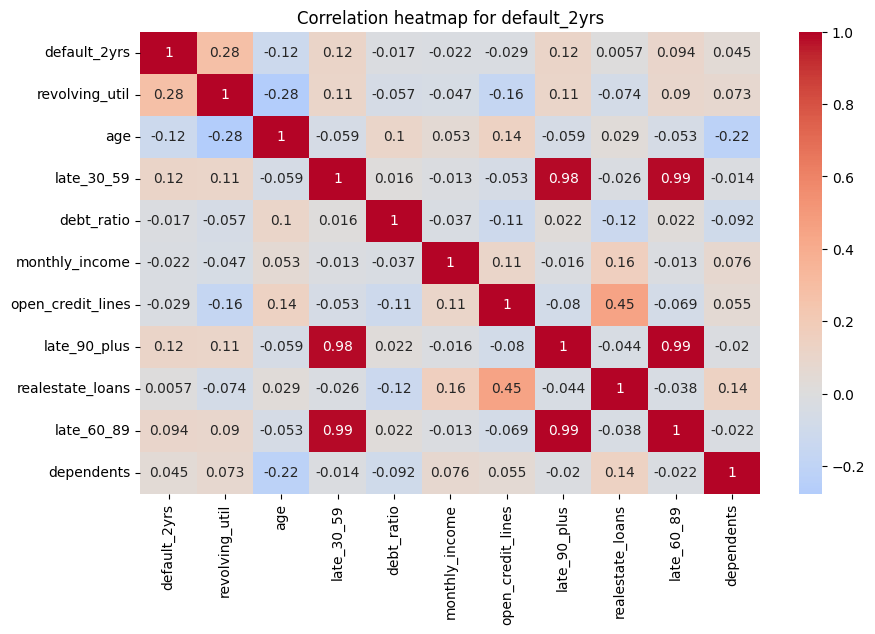

['revolving_util']

In [240]:
tl.get_features_num_regression(df_cred,target_col="default_2yrs",umbral_corr=0.2,pvalue=0.05,mostrar=True)

In [241]:
features_num=["revolving_util","age","late_30_59","debt_ratio","monthly_income","open_credit_lines","late_90_plus","realestate_loans","late_60_89","dependents"]


### #1.2
¿Qué tipo de problema estamos tratando? ¿Cuál es la variable target?

Estamos tratando un problema de regresion

In [242]:
target = "default_2yrs"

### #1.3
Pinta la distribución de frecuencias del target y coméntala

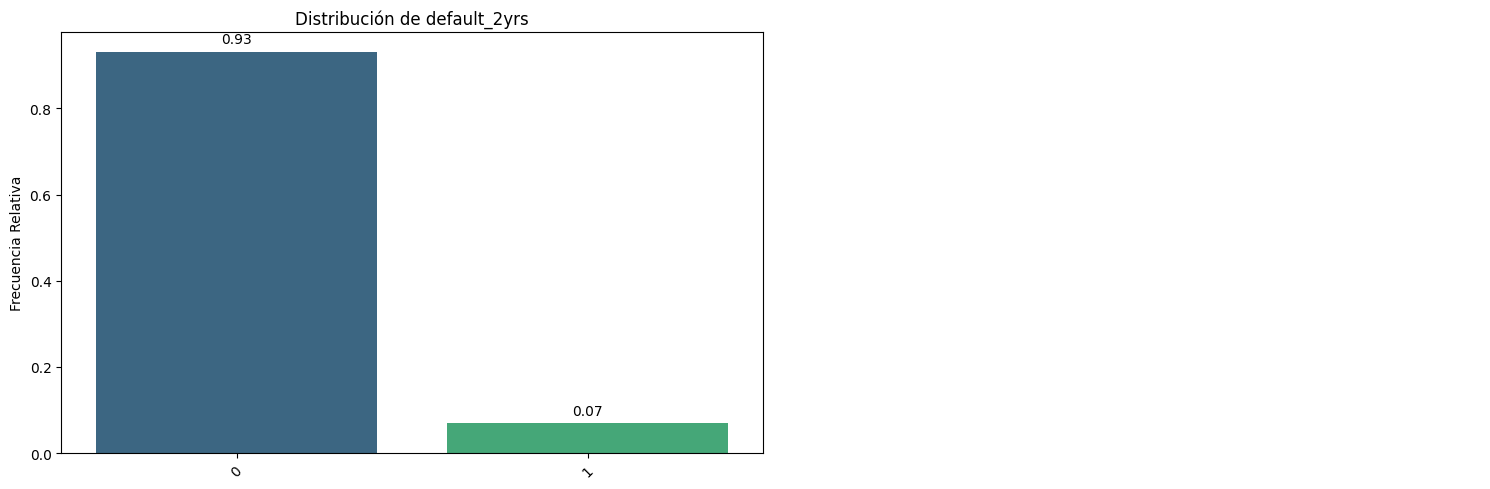

In [243]:
bt.pinta_distribucion_categoricas(df_cred,[target],relativa=True,mostrar_valores=True)

In [244]:
df_cred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12537 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   default_2yrs       12537 non-null  int64  
 1   revolving_util     12537 non-null  float64
 2   age                12537 non-null  int64  
 3   late_30_59         12537 non-null  int64  
 4   debt_ratio         12537 non-null  float64
 5   monthly_income     11816 non-null  float64
 6   open_credit_lines  12537 non-null  int64  
 7   late_90_plus       12537 non-null  int64  
 8   realestate_loans   12537 non-null  int64  
 9   late_60_89         12537 non-null  int64  
 10  dependents         12360 non-null  float64
dtypes: float64(4), int64(7)
memory usage: 1.1 MB


### #2 Modelado

Realiza un proceso completo de modelado hasta dar con el mejor modelo de los que hayas escogido (emplea al menos 3, y uno tiene que ser KNN). Aplica las técnicas que creas necesarias para obtener el mejor resultado (suponiendo que este después de hablar con el negocio es el recall medio, para tener un compromiso entre las dos clases). Para comparar modelos emplea validación cruzada antes de optimización y luego ajusta los hiperparámetros del mejor modelo. Evalúa este y haz un pequeño análisis de errores.

In [245]:
df_cred["monthly_income"].value_counts(dropna=False, normalize=True)

monthly_income
NaN        0.057510
5000.0     0.021935
4000.0     0.016033
6000.0     0.014836
3000.0     0.014517
             ...   
39500.0    0.000080
12040.0    0.000080
8080.0     0.000080
17541.0    0.000080
12016.0    0.000080
Name: proportion, Length: 4168, dtype: float64

In [246]:
df_cred["dependents"].value_counts(dropna=False, normalize=True)

dependents
0.0     0.553163
1.0     0.190157
2.0     0.144851
3.0     0.070352
4.0     0.020180
NaN     0.014118
5.0     0.004945
6.0     0.001914
8.0     0.000160
10.0    0.000080
7.0     0.000080
Name: proportion, dtype: float64

In [247]:
train_set, test_set = train_test_split(df_cred, test_size= 0.2, random_state= 42)

In [248]:
tienen_nulos= ["monthly_income","dependents"]

In [249]:
train_set[tienen_nulos] = train_set[tienen_nulos].replace(0, np.nan)
test_set[tienen_nulos] = test_set[tienen_nulos].replace(0, np.nan)

In [250]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy="median")

train_set[tienen_nulos]= imp.fit_transform(train_set[tienen_nulos])
test_set[tienen_nulos]= imp.fit_transform(test_set[tienen_nulos])

In [251]:
train_set[tienen_nulos].isna().sum()

monthly_income    0
dependents        0
dtype: int64

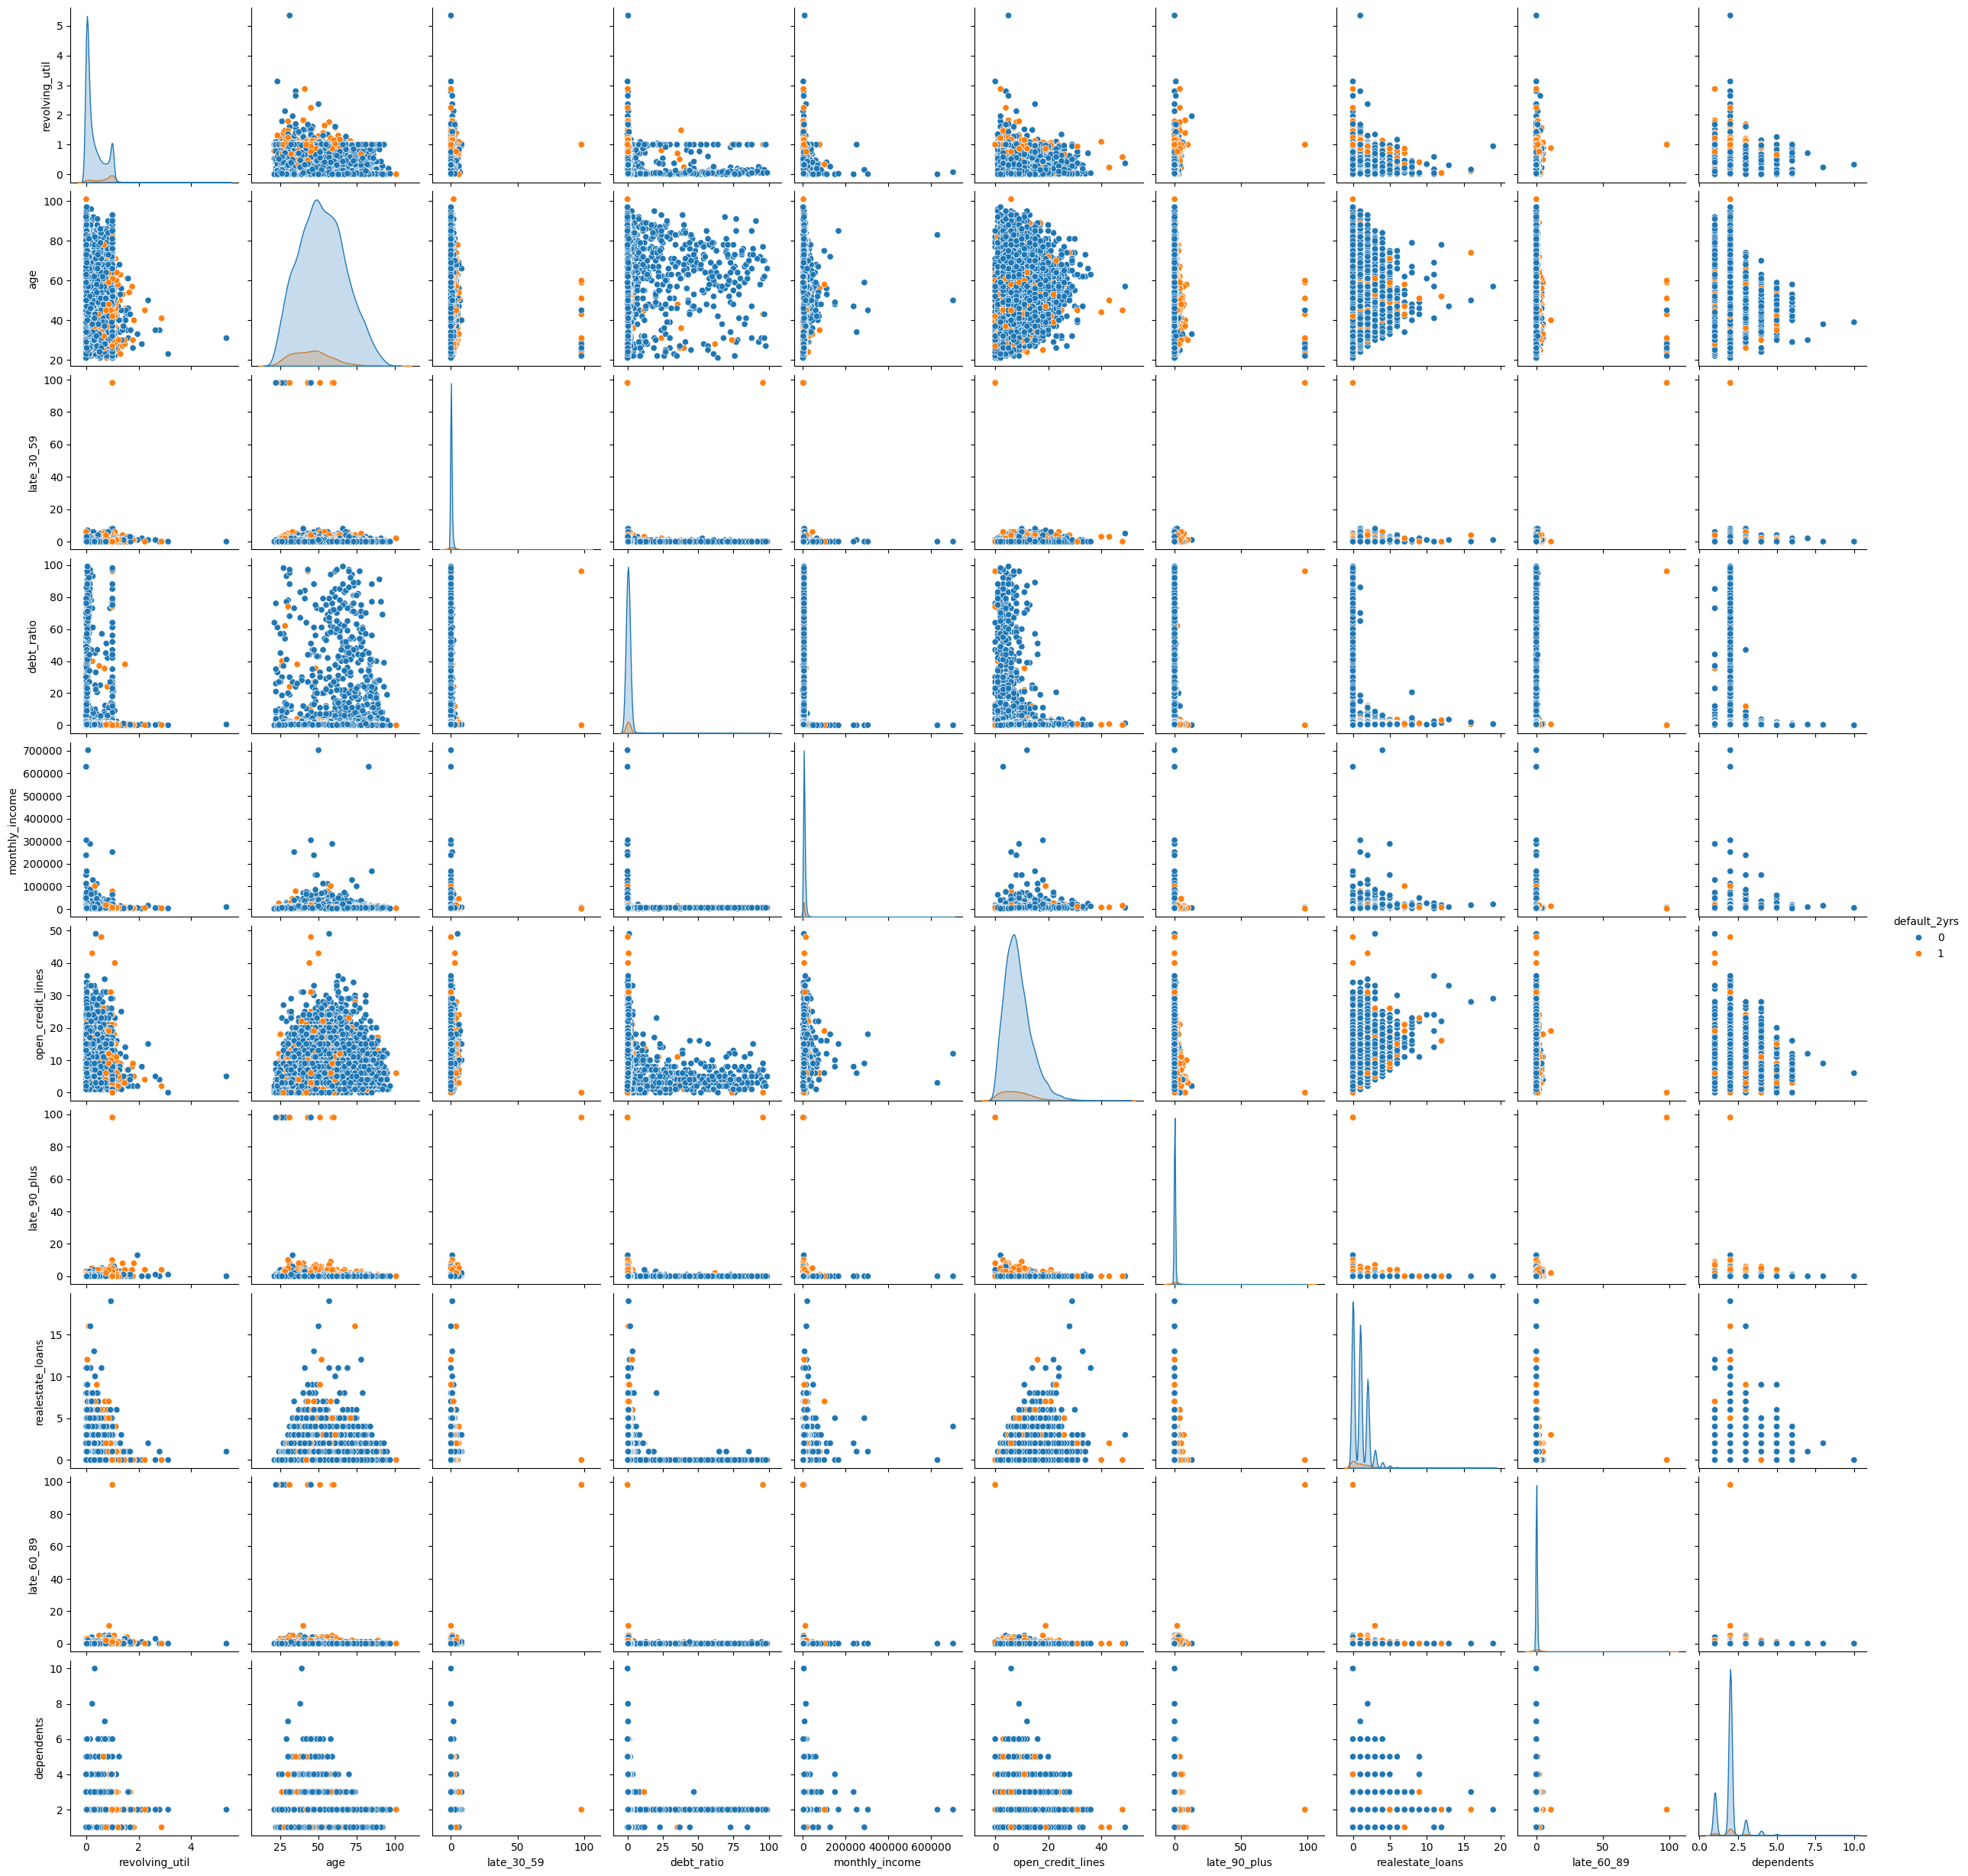

In [231]:
sns.pairplot(train_set,hue=target)

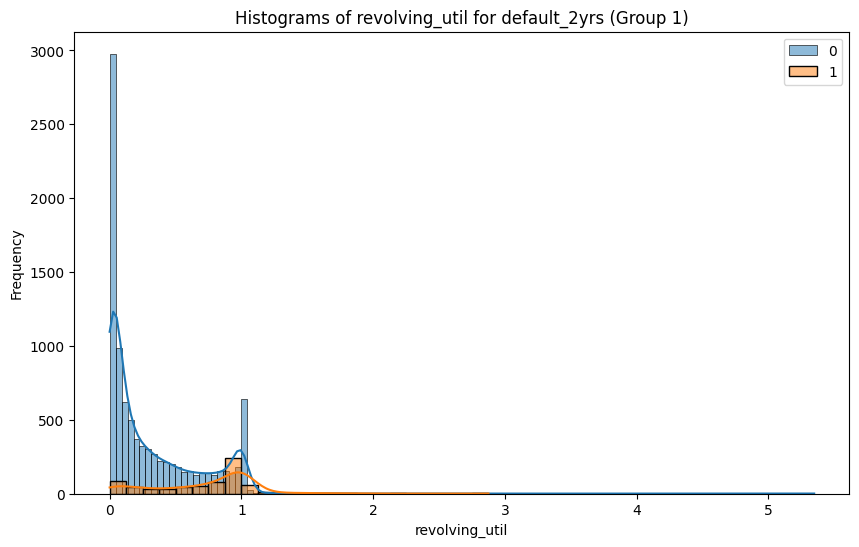

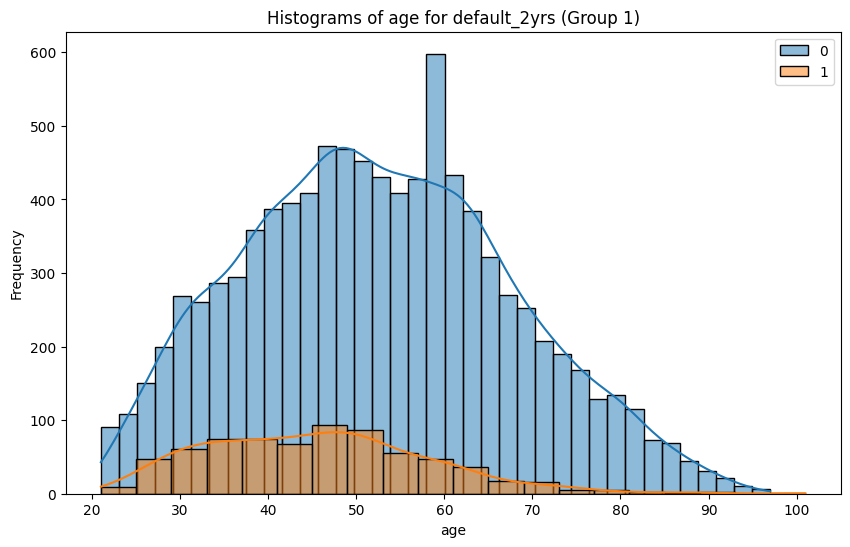

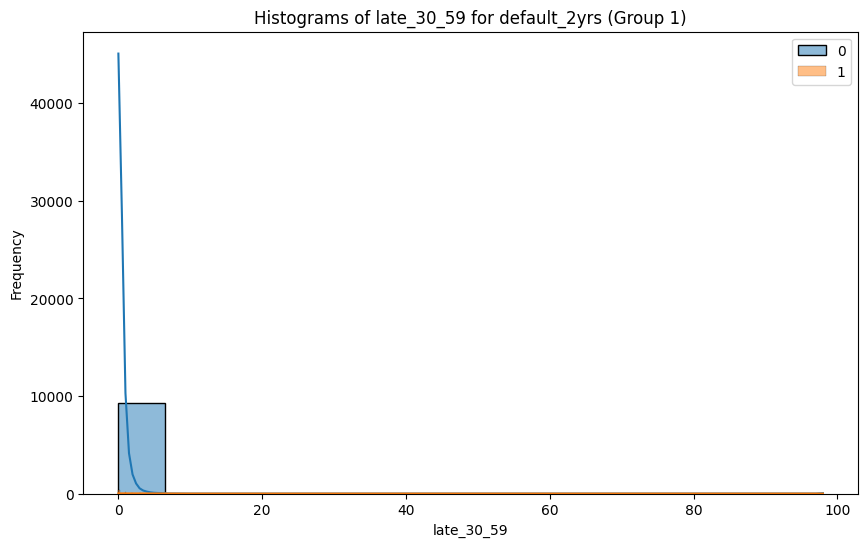

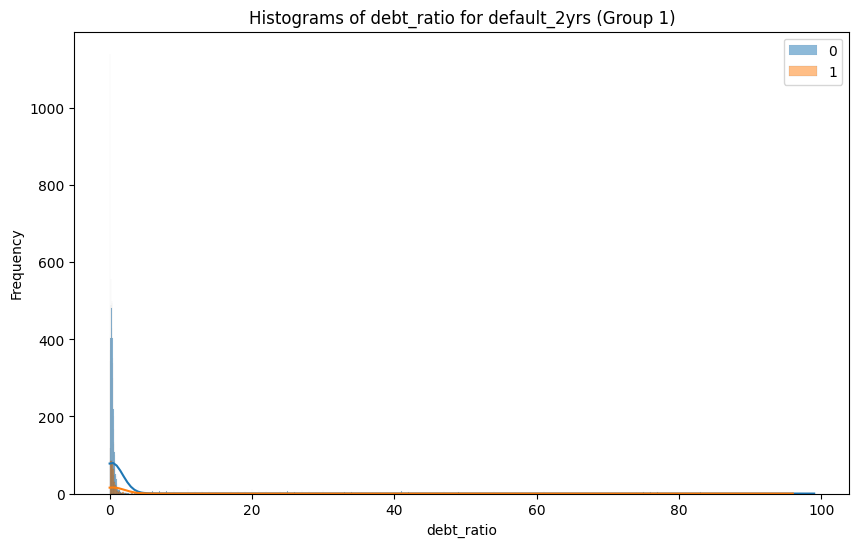

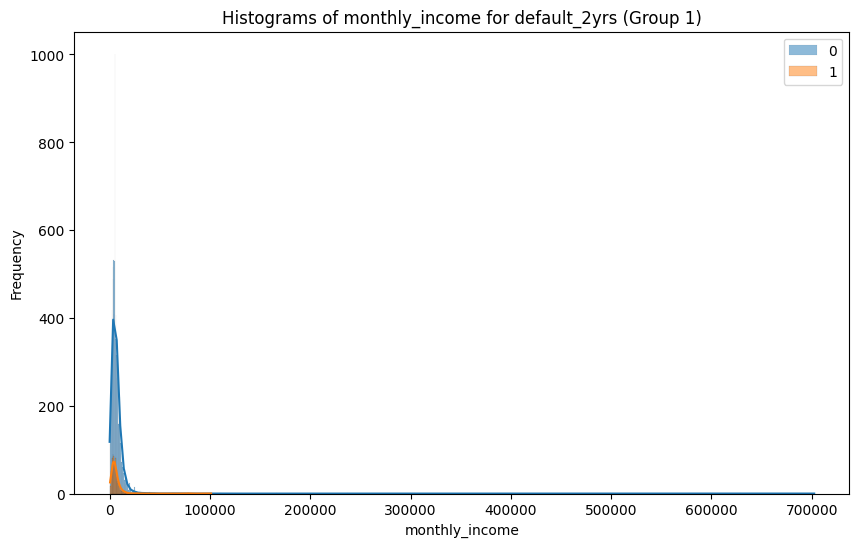

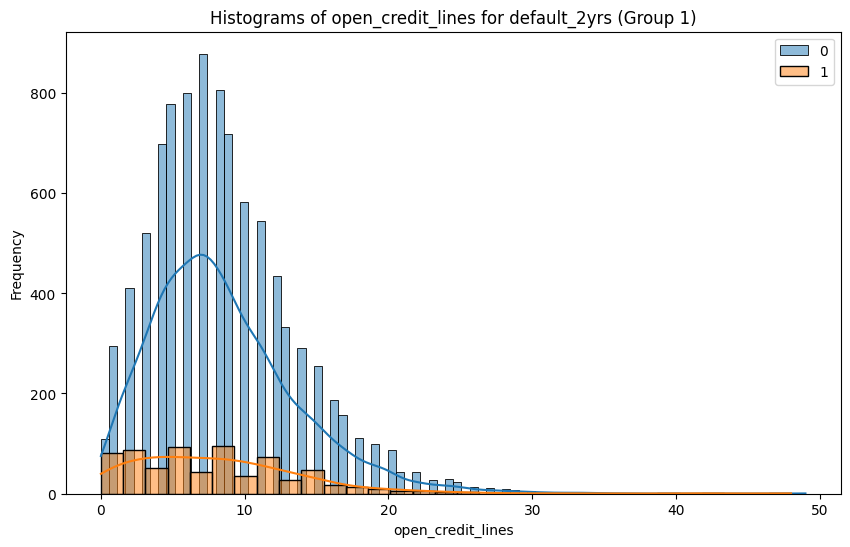

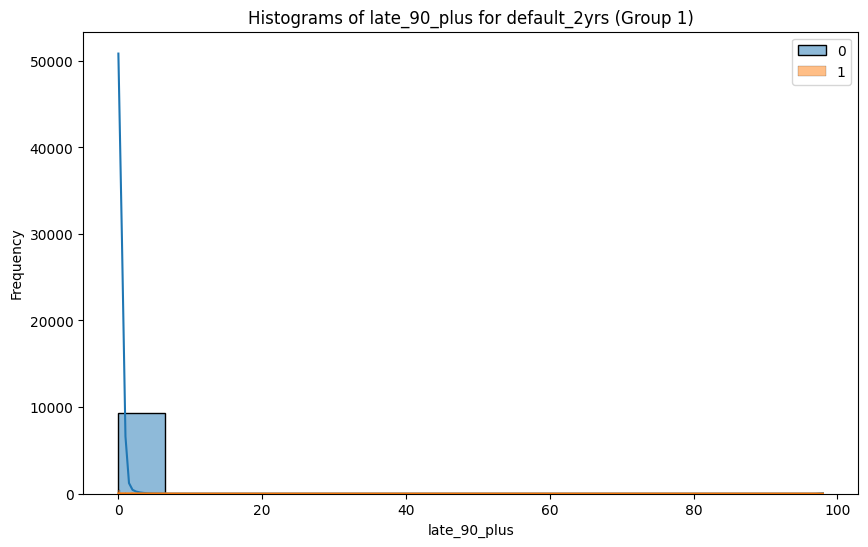

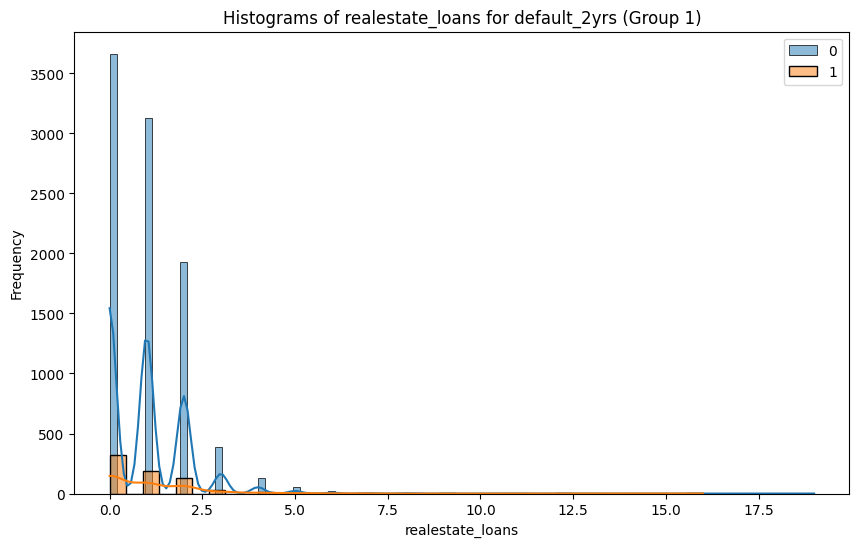

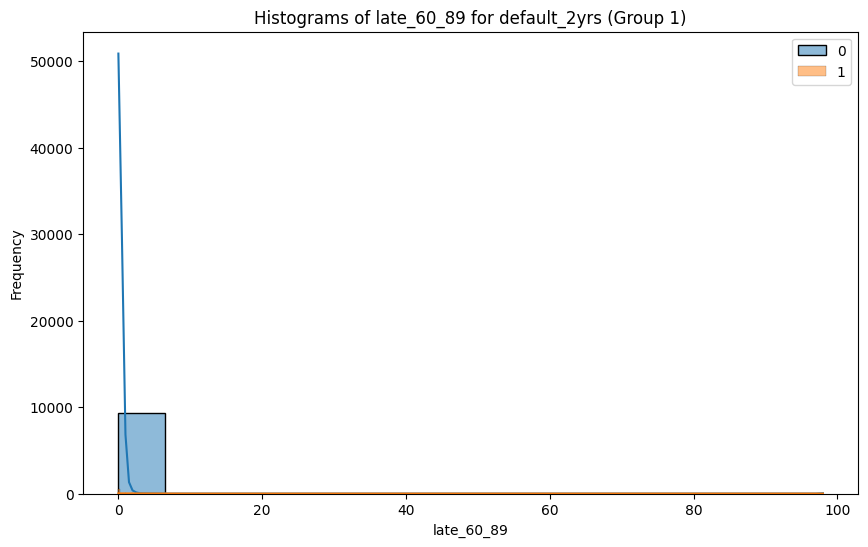

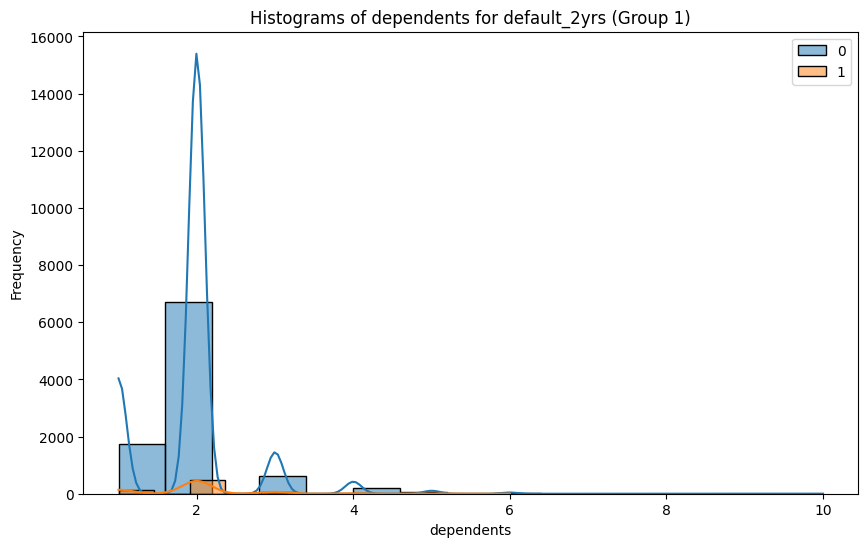

In [203]:
for col in features_num:
    bt.plot_grouped_histograms (train_set,cat_col=target,num_col=col,group_size=3)

In [252]:
train_set.describe()

,default_2yrs,revolving_util,age,late_30_59,debt_ratio,monthly_income,open_credit_lines,late_90_plus,realestate_loans,late_60_89,dependents
count,10029.000000,10029.000000,10029.000000,10029.00000,10029.000000,10029.000000,10029.000000,10029.000000,10029.000000,10029.000000,10029.000000
mean,0.069897,0.332534,52.006681,0.40014,1.859805,6830.023332,8.480905,0.250972,0.997408,0.221258,1.944660
std,0.254987,0.368161,15.064668,3.96043,9.053464,12416.204466,5.150639,3.940818,1.145652,3.923659,0.651031
min,0.000000,0.000000,21.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.030773,41.000000,0.00000,0.142648,3589.000000,5.000000,0.000000,0.000000,0.000000,2.000000
50%,0.000000,0.164421,51.000000,0.00000,0.301520,5416.000000,8.000000,0.000000,1.000000,0.000000,2.000000
75%,0.000000,0.588571,62.000000,0.00000,0.506312,8000.000000,11.000000,0.000000,2.000000,0.000000,2.000000
max,1.000000,5.347652,101.000000,98.00000,99.000000,702500.000000,49.000000,98.000000,19.000000,98.000000,10.000000


In [253]:
X_train= train_set.drop("default_2yrs", axis=1)
y_train= train_set["default_2yrs"]
X_test= test_set.drop("default_2yrs", axis=1)
y_test= test_set["default_2yrs"]

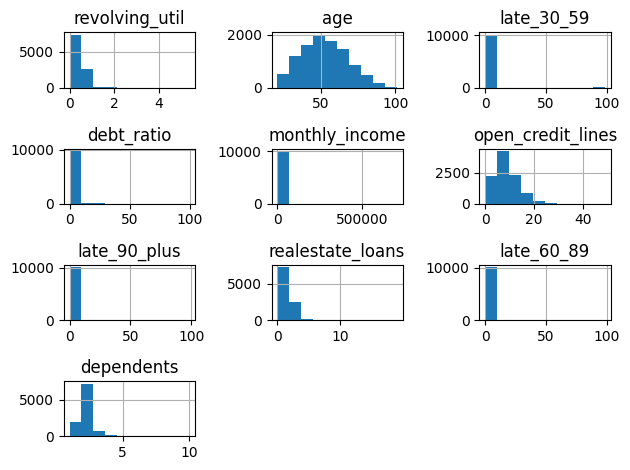

In [300]:
train_set[features_num].hist()
plt.tight_layout()

In [254]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

#### Con un modelo reresion logistica como baselina

In [267]:
lr_clf = LogisticRegression(max_iter = 1000)
lr_clf.fit(X_train, y_train)
y_pred_clf = lr_clf.predict(X_test)
print(classification_report(y_test, y_pred_clf))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2345
           1       0.55      0.04      0.07       163

    accuracy                           0.94      2508
   macro avg       0.74      0.52      0.52      2508
weighted avg       0.91      0.94      0.91      2508



c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Conclusión:
El modelo es muy bueno para predecir la clase negativa (0), pero prácticamente no detecta la clase positiva (1).

Esto es típico en datasets muy desbalanceados.

## Apliquemos un KNN

In [255]:
from sklearn.neighbors import KNeighborsClassifier
n_neighbors = 5

knn = KNeighborsClassifier(n_neighbors)
knn.fit(X_train_s, y_train)

KNeighborsClassifier()

In [261]:
print(classification_report(y_train,knn.predict(X_train_s)))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      9328
           1       0.74      0.15      0.26       701

    accuracy                           0.94     10029
   macro avg       0.84      0.58      0.61     10029
weighted avg       0.93      0.94      0.92     10029



In [260]:
print(classification_report(y_test,knn.predict(X_test_s)))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97      2345
           1       0.44      0.09      0.14       163

    accuracy                           0.93      2508
   macro avg       0.69      0.54      0.55      2508
weighted avg       0.91      0.93      0.91      2508



In [259]:
scores = np.mean(cross_val_score(knn, X_train_s, y_train, cv=5, scoring='accuracy'))
print(scores)

0.9272112838541731


 Se ve claramente un problema de desbalanceo en la variable target
 
 ¿Por qué pasa esto?
Desbalance de clases: Hay muchas más observaciones de la clase 0 que de la clase 1 

KNN tiende a favorecer las clases mayoritarias, especialmente si no hay una estrategia para tratar el desbalance.

¿Qué hacer para mejorar?

Balancear el dataset con técnicas como:

Oversampling (SMOTE)

Undersampling

## Aplicaremos un Oversampling (SMOTE)

In [262]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_s,y_train)

In [263]:
y_train_smote.value_counts()

default_2yrs
0    9328
1    9328
Name: count, dtype: int64

In [264]:
n_neighbors = 5

knn = KNeighborsClassifier(n_neighbors)
knn.fit(X_train_smote, y_train_smote)

KNeighborsClassifier()

In [265]:
print(classification_report(y_test, knn.predict(X_test_s)))

              precision    recall  f1-score   support

           0       0.96      0.84      0.90      2345
           1       0.17      0.47      0.25       163

    accuracy                           0.82      2508
   macro avg       0.57      0.66      0.58      2508
weighted avg       0.91      0.82      0.86      2508



SMOTE ayudó a detectar mejor la clase minoritaria (default), aumentando el recall de 0.09 a 0.47.

In [269]:
from catboost import CatBoostClassifier

cat_clf = CatBoostClassifier(max_depth= 5, verbose= False, auto_class_weights= "Balanced")

In [270]:
np.mean(cross_val_score(cat_clf,X_train,y_train,cv=5,scoring="balanced_accuracy"))

np.float64(0.7492721444308803)

In [271]:
cat_clf.fit(X_train,y_train)

In [272]:
print(classification_report(y_test, cat_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91      2345
           1       0.23      0.61      0.33       163

    accuracy                           0.84      2508
   macro avg       0.60      0.73      0.62      2508
weighted avg       0.92      0.84      0.87      2508



### Este modedlo dice:
Estás sacrificando precisión en la clase 1 para aumentar su recall, lo cual es útil en casos de riesgo crediticio, donde es mejor detectar a alguien en riesgo (aunque se generen algunos falsos positivos).

### Vamos a emplear un Catboost con SMOTE

In [274]:
from catboost import CatBoostClassifier

cat_clf = CatBoostClassifier(max_depth= 5, verbose= False, auto_class_weights= "Balanced")

cat_clf.fit(X_train_smote,y_train_smote)

In [275]:
print(classification_report(y_test, cat_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      2345
           1       0.36      0.31      0.33       163

    accuracy                           0.92      2508
   macro avg       0.66      0.63      0.65      2508
weighted avg       0.91      0.92      0.92      2508



### Mejor modelo según recall macro:
CatBoost sin SMOTE (recall macro = 0.73)
Este modelo logra el mejor recall medio entre las dos clases, que es tu métrica prioritaria. Además, mantiene un accuracy razonablemente alto (0.84) y un recall de clase 1 bastante aceptable (0.61), lo cual es clave si queremos identificar correctamente a quienes sí van a caer en default.

In [277]:
from sklearn.model_selection import GridSearchCV

In [279]:
cat_model = CatBoostClassifier(verbose=0, random_state=42)

# Grid de hiperparámetros
param_grid = {
    'depth': [4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [100, 300],
    'l2_leaf_reg': [1, 3, 5],
    'auto_class_weights': ['Balanced']
}

# GridSearchCV
grid_search = GridSearchCV(
    estimator=cat_model,
    param_grid=param_grid,
    scoring='recall_macro',
    n_jobs=-1
)

In [280]:
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x000001B98E0BB7C0>,
             n_jobs=-1,
             param_grid={'auto_class_weights': ['Balanced'], 'depth': [4, 5, 6],
                         'iterations': [100, 300], 'l2_leaf_reg': [1, 3, 5],
                         'learning_rate': [0.01, 0.05, 0.1]},
             scoring='recall_macro')

In [283]:
print(classification_report(y_test, grid_search.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.80      0.88      2345
           1       0.20      0.72      0.31       163

    accuracy                           0.79      2508
   macro avg       0.59      0.76      0.60      2508
weighted avg       0.93      0.79      0.84      2508



In [284]:
np.mean(cross_val_score(grid_search,X_train,y_train,cv=5,scoring="balanced_accuracy"))

np.float64(0.7773294619489849)

Conclusión del Modelo
Tras evaluar diversos algoritmos de clasificación, el modelo basado en CatBoostClassifier con ajuste de hiperparámetros mostró el mejor desempeño en relación al criterio de negocio prioritario: maximizar el recall de la clase minoritaria (default = 1).

Este modelo logró un recall del 72% para la clase 1, superando significativamente a las demás alternativas exploradas. Esto implica una capacidad superior para identificar correctamente a los clientes con mayor probabilidad de incumplimiento, lo cual es clave para minimizar los falsos negativos y mejorar la gestión del riesgo crediticio.

Aunque se observa una disminución en precisión y accuracy general, este resultado es coherente con el objetivo planteado, ya que en escenarios de desbalance de clases, un alto recall es preferible cuando el costo de no detectar casos positivos es elevado.

En resumen, el modelo final seleccionado con CatBoost optimizado representa la mejor opción para el negocio, al lograr un equilibrio adecuado entre sensibilidad y generalización, priorizando la detección de eventos críticos.

El modelo optimizado mediante Grid Search alcanzó un balanced accuracy promedio de 0.78 en validación cruzada, lo que indica un buen desempeño equilibrado entre ambas clases en un problema con datos desbalanceados. Este resultado sugiere que el modelo es capaz de identificar correctamente tanto la clase mayoritaria como la minoritaria, alineándose con el objetivo principal de maximizar el recall de la clase minoritaria.